In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
!nvidia-smi



Wed Jan 14 17:51:30 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/Skin Disease new.v2i.coco-20260114T071538Z-1-001.zip"
extract_path = "data/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

base_dir = "/content/data/Skin Disease new.v2i.coco"

train_dir = os.path.join(base_dir, "train_classification")
val_dir   = os.path.join(base_dir, "valid_classification")
test_dir  = os.path.join(base_dir, "test_classification")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# New Section

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225]
#     )
# ])

train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data   = datasets.ImageFolder(val_dir, transform=transform)
test_data  = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=8)
test_loader  = DataLoader(test_data, batch_size=8)

num_classes = len(train_data.classes)


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )


    def forward(self, x):
        return self.conv(x)


class UNet_Classifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.enc1 = DoubleConv(3,32)
        self.enc2 = DoubleConv(32,64)
        self.enc3 = DoubleConv(64, 128)
        self.enc4 = DoubleConv(128, 256)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(256,512)

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(self.enc1(x))
        x = self.pool(self.enc2(x))
        x = self.pool(self.enc3(x))
        x = self.pool(self.enc4(x))

        x = self.bottleneck(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [ ]:
model = UNet_Classifier(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0005)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


print("Total parameters:",
      sum(p.numel() for p in model.parameters()))


Total parameters: 4717867


In [ ]:
def train_one_epoch(loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(loader)
    acc = correct / total

    return avg_loss, acc


In [ ]:
def evaluate(loader):
    model.eval()
    correct =0
    total =0
    all_labels =[]
    all_predictions =[]

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    return correct / total, np.array(all_labels), np.array(all_predictions)

In [ ]:
import torch
print(torch.cuda.is_available())



True


In [ ]:
epochs = 60

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(train_loader)
    val_acc, _, _ = evaluate(val_loader)

    print(f" Step {epoch} [{epoch+1}/{epochs}] "
          f"Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | "
          f"Val Acc: {val_acc:.4f}")


 Step 0 [1/60] Loss: 2.3068 | Train Acc: 0.1406 | Val Acc: 0.1722
 Step 1 [2/60] Loss: 2.1271 | Train Acc: 0.2202 | Val Acc: 0.2609
 Step 2 [3/60] Loss: 2.0053 | Train Acc: 0.2862 | Val Acc: 0.2795
 Step 3 [4/60] Loss: 1.9151 | Train Acc: 0.3002 | Val Acc: 0.2702
 Step 4 [5/60] Loss: 1.8641 | Train Acc: 0.3196 | Val Acc: 0.3060
 Step 5 [6/60] Loss: 1.8092 | Train Acc: 0.3441 | Val Acc: 0.2954
 Step 6 [7/60] Loss: 1.7451 | Train Acc: 0.3744 | Val Acc: 0.3444
 Step 7 [8/60] Loss: 1.7271 | Train Acc: 0.3806 | Val Acc: 0.3629
 Step 8 [9/60] Loss: 1.6775 | Train Acc: 0.4117 | Val Acc: 0.3868
 Step 9 [10/60] Loss: 1.6191 | Train Acc: 0.4303 | Val Acc: 0.4106
 Step 10 [11/60] Loss: 1.5655 | Train Acc: 0.4509 | Val Acc: 0.4106
 Step 11 [12/60] Loss: 1.5497 | Train Acc: 0.4610 | Val Acc: 0.4146
 Step 12 [13/60] Loss: 1.4869 | Train Acc: 0.4944 | Val Acc: 0.4437
 Step 13 [14/60] Loss: 1.4309 | Train Acc: 0.5010 | Val Acc: 0.4821
 Step 14 [15/60] Loss: 1.3596 | Train Acc: 0.5274 | Val Acc: 0.5020

In [ ]:
test_acc, y_true, y_pred = evaluate(test_loader)
print("Test Accuracy:", test_acc)

classes = train_data.classes


Test Accuracy: 0.7777777777777778


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

print(cm)


[[31  4  0  0  0  0  3  0  0  0  0]
 [ 0 24  0  2  0  2  0  0  0  2  1]
 [ 0  0 29  0  0  1  1  0  1  0  0]
 [ 0  2  0 30  0  0  2  0  0  3  0]
 [ 0  0  0  0 27  0  0  0  0  0  0]
 [ 0  1  1  0  0 24  6  0  0  0  6]
 [ 1  1  1  2  0  1 17  2  0  3  9]
 [ 0  0  0  1  0  0  0 36  0  0  0]
 [ 0  0  1  0  0  0  0  0 12  0  2]
 [ 0  0  0  0  0  1  2  0  0 44  4]
 [ 0  1  0  3  0  5  2  0  0  4 20]]


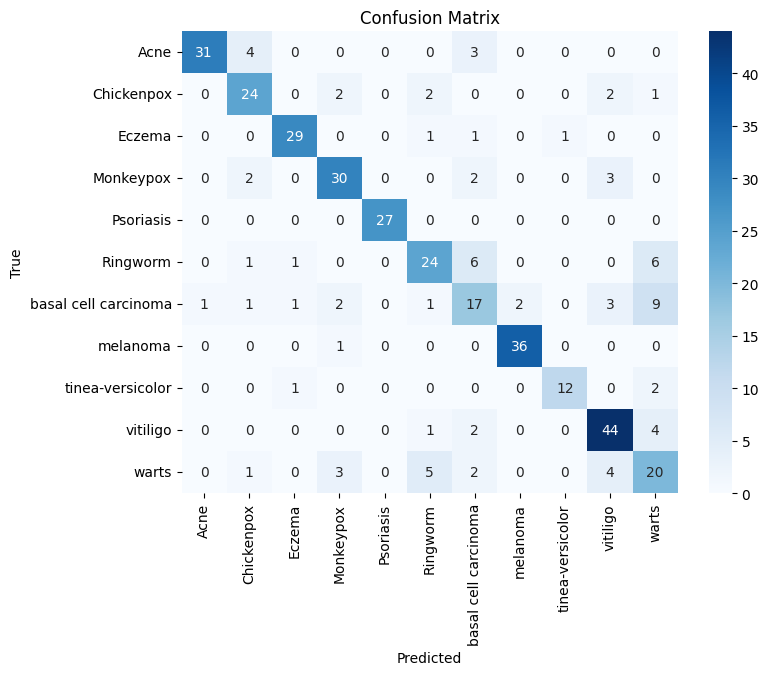

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
classes = train_data.classes

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
